## 1. Importy

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import permutation_test
from statsmodels.formula.api import ols
from scipy import stats
import statsmodels.graphics.gofplots as sm
from itertools import combinations
from sklearn.impute import SimpleImputer

## 2. Funkcje

In [2]:
def plot(data, res, feature, prediction):
    fig, axs = plt.subplots(2,2, squeeze=False)
    data['Prediction'] = res.predict(data)
    plt.tight_layout()

    ax = data.plot.scatter(x=feature,y=prediction, ax=axs[0,0])
    data.plot(x=feature,y='Prediction', ax=axs[0,0], color='red', style='s')
    # plt.subplot(2,2,2)
    residuals = res.predict(data)-data[prediction]
    axs[0,1].scatter(data[feature], (residuals))
    axs[0,1].set_xlabel(feature)
    axs[0,1].set_ylabel('Residual values')

    axs[1,0].hist(residuals)
    axs[1,0].set_ylabel('frequency')
    axs[1,0].set_xlabel('residuual values')
    plt.subplot(2,2,4)
    sm.qqplot(residuals, stats.t, distargs=(4,), loc=3, scale=10, fit=True, ax=axs[1,1], line='s')
    plt.tight_layout()

def statistic(x, y, axis=0):
    return np.mean(x, axis=axis) - np.mean(y, axis=axis)

def ABtests(dataframe, store_types, feature1, feature2):

    alpha = 0.05
    for type1, type2 in combinations(store_types, 2):
        group1 = dataframe[dataframe[feature1] == type1][feature2]
        group2 = dataframe[dataframe[feature1] == type2][feature2]

        stats = permutation_test((group1, group2), statistic,
                            alternative='two-sided', n_resamples=100)

        p_value = stats.pvalue.round(5)
        observed = stats.statistic.round(5)
        null_distribution = stats.null_distribution


        print(f'Porównanie między {type1} a {type2}:')
        print(f'Statystyka testowa: {observed}')
        print(f'Wartość p: {p_value}')

        if p_value < alpha:
            print("Odrzucamy H0 na poziomie istotności 0.05. Istnieje istotna różnica między grupami.")
        else:
            print("Nie ma wystarczających dowodów na odrzucenie H0. Brak istotnej różnicy między grupami.")
        print('\n')

## 3. Wczytywanie i obróbka danych danych

In [20]:
df_sales_raw = pd.read_csv("store_data.csv", low_memory=False)
df_store_raw = pd.read_csv("store.csv", low_memory=False)

df_states_raw = pd.read_csv("state_names.csv", low_memory=False)
df_store_states_raw = pd.read_csv("store_states.csv", low_memory=False)
df_weather_raw = pd.read_csv("weather.csv", low_memory=False)
df_weather_raw.rename(columns={'file': 'State'}, inplace=True)

label_encoder = LabelEncoder()
# df_sales_raw['StateHoliday'] = pd.to_numeric(df_sales_raw['StateHoliday'], errors='coerce').fillna(0).astype(int)
# df_sales_raw['SchoolHoliday'] = pd.to_numeric(df_sales_raw['SchoolHoliday'], errors='coerce').astype(int)


df_store_raw['StoreType'] = df_store_raw['StoreType'].map({'a': 0, 'b': 1, 'c': 2, 'd': 3})
df_store_raw['Assortment'] = df_store_raw['Assortment'].map({'a': 0, 'b': 1, 'c': 2})
df_sales_raw['StateHoliday'] = df_sales_raw['StateHoliday'].map({"0": 0, 'a': 1, 'b': 2, 'c': 3})

df_weather_raw['Events'] = label_encoder.fit_transform(df_weather_raw['Events'])

print("Przypisane wartości:")
for category, encoded_value in zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)):
    print(f"{category}: {encoded_value}")


Przypisane wartości:
Fog: 0
Fog-Rain: 1
Fog-Rain-Hail: 2
Fog-Rain-Hail-Thunderstorm: 3
Fog-Rain-Snow: 4
Fog-Rain-Snow-Hail: 5
Fog-Rain-Thunderstorm: 6
Fog-Snow: 7
Fog-Snow-Hail: 8
Fog-Thunderstorm: 9
Rain: 10
Rain-Hail: 11
Rain-Hail-Thunderstorm: 12
Rain-Snow: 13
Rain-Snow-Hail: 14
Rain-Snow-Hail-Thunderstorm: 15
Rain-Snow-Thunderstorm: 16
Rain-Thunderstorm: 17
Snow: 18
Snow-Hail: 19
Thunderstorm: 20
nan: 21


In [21]:
df_raw = pd.merge(df_sales_raw, df_store_raw, how="left", on="Store")
df_raw = pd.merge(df_raw, df_store_states_raw, how="left", on="Store")

df_raw['State'] = df_raw['State'].map(dict(zip(df_states_raw['State'], df_states_raw['StateName'])))


# print(df_raw['State'].unique())
# print(df_weather_raw['file'].unique())
df_raw = pd.merge(df_raw, df_weather_raw, how="left", left_on=['Date', 'State'], right_on=['Date', 'State'])

df_raw['Date'] = pd.to_datetime(df_raw['Date'])
df_raw['Day'] = df_raw['Date'].dt.day
df_raw['Month'] = df_raw['Date'].dt.month
df_raw['Year'] = df_raw['Date'].dt.year
df_raw['DayOfWeek'] = df_raw['Date'].dt.weekday # poniedzialek to 0, niedzielaa to 6

df_raw['State'] = label_encoder.fit_transform(df_raw['State'])

df_raw['BasketValue'] = df_raw['Sales'] / df_raw['Customers']

print("Number of Rows: {}".format(df_raw.shape[0]))
print("NUmber of Cols: {}".format(df_raw.shape[1]))

df_raw

Number of Rows: 1017209
NUmber of Cols: 45


,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,...,Mean_Wind_SpeedKm_h,Max_Gust_SpeedKm_h,Precipitationmm,CloudCover,Events,WindDirDegrees,Day,Month,Year,BasketValue
0,1,4,2015-07-31,5263,555,1,1,0,1,2,...,11,NaN,0.00,1.0,0,13,31,7,2015,9.482883
1,2,4,2015-07-31,6064,625,1,1,0,1,0,...,11,NaN,0.00,4.0,0,309,31,7,2015,9.702400
2,3,4,2015-07-31,8314,821,1,1,0,1,0,...,5,NaN,0.00,2.0,0,354,31,7,2015,10.126675
3,4,4,2015-07-31,13995,1498,1,1,0,1,2,...,16,NaN,0.00,6.0,21,282,31,7,2015,9.342457
4,5,4,2015-07-31,4822,559,1,1,0,1,0,...,11,NaN,0.00,4.0,21,290,31,7,2015,8.626118
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1017204,1111,1,2013-01-01,0,0,0,0,1,1,0,...,26,58.0,5.08,6.0,10,215,1,1,2013,NaN
1017205,1112,1,2013-01-01,0,0,0,0,1,1,2,...,26,58.0,5.08,6.0,10,215,1,1,2013,NaN
1017206,1113,1,2013-01-01,0,0,0,0,1,1,0,...,16,NaN,0.00,6.0,10,251,1,1,2013,NaN
1017207,1114,1,2013-01-01,0,0,0,0,1,1,0,...,23,63.0,6.10,6.0,10,234,1,1,2013,NaN


In [22]:
df_raw.dtypes

Store                                  int64
DayOfWeek                              int64
Date                          datetime64[ns]
Sales                                  int64
Customers                              int64
Open                                   int64
Promo                                  int64
StateHoliday                           int64
SchoolHoliday                          int64
StoreType                              int64
Assortment                             int64
CompetitionDistance                  float64
CompetitionOpenSinceMonth            float64
CompetitionOpenSinceYear             float64
Promo2                                 int64
Promo2SinceWeek                      float64
Promo2SinceYear                      float64
PromoInterval                         object
State                                  int64
Max_TemperatureC                       int64
Mean_TemperatureC                      int64
Min_TemperatureC                       int64
Dew_PointC

In [23]:
df_raw['StateHoliday']
# df_raw['StateHoliday'] = df_raw['StateHoliday'].astype('category')

0          0
1          0
2          0
3          0
4          0
          ..
1017204    1
1017205    1
1017206    1
1017207    1
1017208    1
Name: StateHoliday, Length: 1017209, dtype: int64

In [24]:
df_raw.isna().mean()

Store                         0.000000
DayOfWeek                     0.000000
Date                          0.000000
Sales                         0.000000
Customers                     0.000000
Open                          0.000000
Promo                         0.000000
StateHoliday                  0.000000
SchoolHoliday                 0.000000
StoreType                     0.000000
Assortment                    0.000000
CompetitionDistance           0.002597
CompetitionOpenSinceMonth     0.317878
CompetitionOpenSinceYear      0.317878
Promo2                        0.000000
Promo2SinceWeek               0.499436
Promo2SinceYear               0.499436
PromoInterval                 0.499436
State                         0.000000
Max_TemperatureC              0.000000
Mean_TemperatureC             0.000000
Min_TemperatureC              0.000000
Dew_PointC                    0.000000
MeanDew_PointC                0.000000
Min_DewpointC                 0.000000
Max_Humidity             

In [25]:
numeric_cols = df_raw.select_dtypes(include=[np.number]).columns
df_numeric = df_raw[numeric_cols]

imp_median = SimpleImputer(missing_values=np.nan, strategy='median') 
df_numeric_imputed = pd.DataFrame(imp_median.fit_transform(df_numeric), columns=df_numeric.columns)

df_raw[numeric_cols] = df_numeric_imputed


In [26]:
df_raw.isna().mean()

Store                         0.000000
DayOfWeek                     0.000000
Date                          0.000000
Sales                         0.000000
Customers                     0.000000
Open                          0.000000
Promo                         0.000000
StateHoliday                  0.000000
SchoolHoliday                 0.000000
StoreType                     0.000000
Assortment                    0.000000
CompetitionDistance           0.000000
CompetitionOpenSinceMonth     0.000000
CompetitionOpenSinceYear      0.000000
Promo2                        0.000000
Promo2SinceWeek               0.000000
Promo2SinceYear               0.000000
PromoInterval                 0.499436
State                         0.000000
Max_TemperatureC              0.000000
Mean_TemperatureC             0.000000
Min_TemperatureC              0.000000
Dew_PointC                    0.000000
MeanDew_PointC                0.000000
Min_DewpointC                 0.000000
Max_Humidity             

In [27]:
# miesiace promocji
month_map = {1: "Jan", 2: "Fev", 3: "Mar", 4: "Apr", 5: "May", 6: "Jun", 7: "Jul", 8: "Aug", 9: "Sep", 10: "Oct", 11: "Nov", 12: "Dec"}

## 4. Analiza danych

### 4.1 Korelacja oraz dendogram dla danych całościowych

/tmp/ipykernel_10805/2788221449.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corrmat = df_raw.corr()


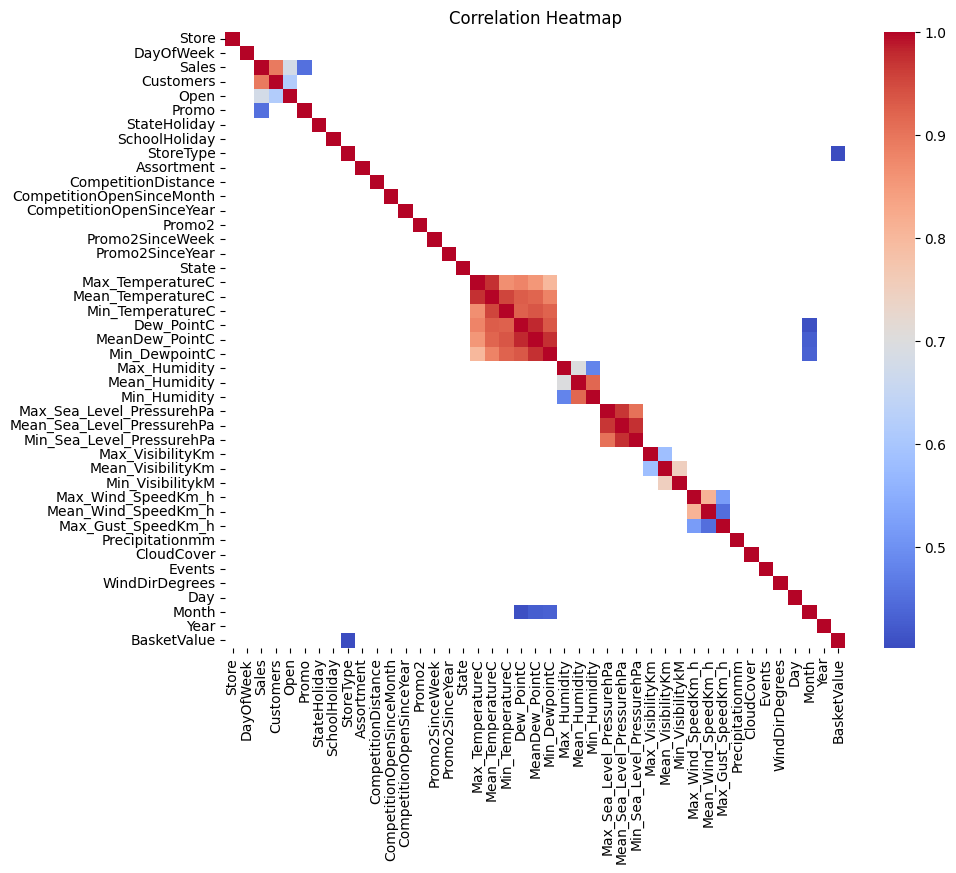

In [28]:
plt.figure(figsize=(10, 8))
corrmat = df_raw.corr()

high_corr = corrmat[corrmat > 0.4]

sns.heatmap(high_corr, annot=False, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()


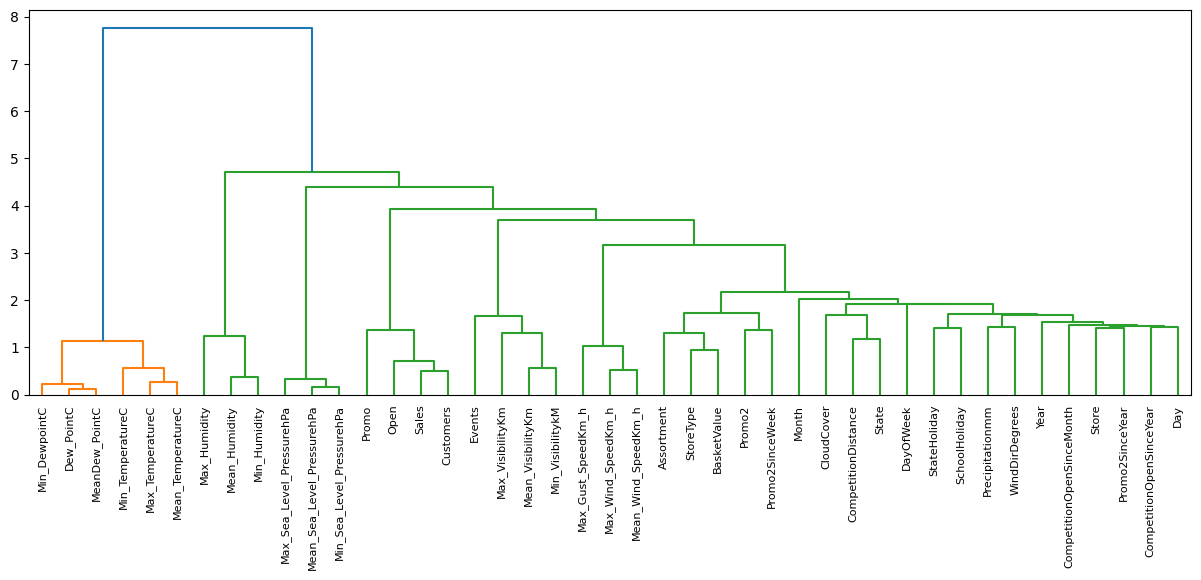

In [29]:
from scipy.cluster import hierarchy
finite_corrmat = np.nan_to_num(corrmat)
Z = hierarchy.linkage(finite_corrmat, 'ward')
plt.figure(figsize=(15,5))
dn = hierarchy.dendrogram(Z, labels=corrmat.columns)


### Z przeprowadzonej korelacji oraz wyznaczenie dendogramu wynika iż cena produktu najbardziej zależy od promocji, tego czy sklep działa oraz ilości klientów

## 4.2. Czynniki wpływające na sprzedaż oraz na liczbę odwiedzających i wartość koszyka

Bartłomiej Gasyna
kaczmar: 

najpierw wykreślić boxploty (widać tam ze np. w niedziele są zamknięte sklepy i to trzeba uwzględnić)

potem korelacje (cena w przeliczeniu na klienta)

regresja np. OLS

#### 4.2.1. Typ sklepu

#### Ilość danych typów sklepów

In [30]:
df_raw['StoreType'].value_counts()

0.0    551627
3.0    312912
2.0    136840
1.0     15830
Name: StoreType, dtype: int64

#### Boxplot

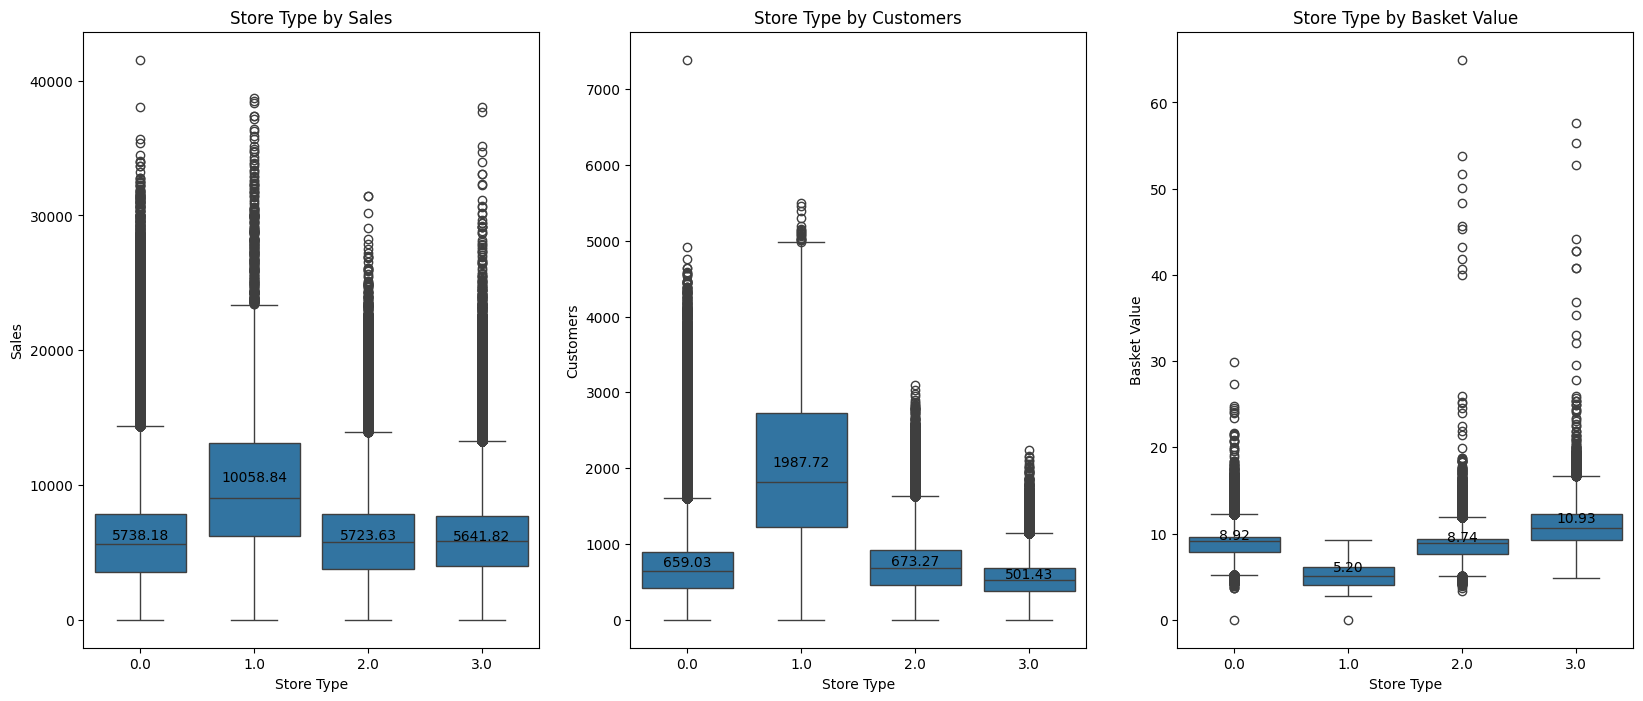

In [31]:
fig, ax = plt.subplots(1, 3, figsize=(20, 8))

sns.boxplot(x='StoreType', y='Sales', data=df_raw, ax=ax[0])
ax[0].set_title('Store Type by Sales')
ax[0].set_xlabel('Store Type')
ax[0].set_ylabel('Sales')


mean_sales = df_raw.groupby('StoreType')['Sales'].mean()
for i, mean in enumerate(mean_sales):
    ax[0].text(i, mean, f'{mean:.2f}', ha='center', va='bottom')

sns.boxplot(x='StoreType', y='Customers', data=df_raw, ax=ax[1])
ax[1].set_title('Store Type by Customers')
ax[1].set_xlabel('Store Type')
ax[1].set_ylabel('Customers')


mean_customers = df_raw.groupby('StoreType')['Customers'].mean()
for i, mean in enumerate(mean_customers):
    ax[1].text(i, mean, f'{mean:.2f}', ha='center', va='bottom')

sns.boxplot(x='StoreType', y='BasketValue', data=df_raw, ax=ax[2])
ax[2].set_title('Store Type by Basket Value')
ax[2].set_xlabel('Store Type')
ax[2].set_ylabel('Basket Value')


mean_basket_value = df_raw.groupby('StoreType')['BasketValue'].mean()
for i, mean in enumerate(mean_basket_value):
    ax[2].text(i, mean, f'{mean:.2f}', ha='center', va='bottom')

plt.show()


StoreType      1.000000
Sales         -0.013057
Customers     -0.141423
BasketValue    0.402678
Name: StoreType, dtype: float64


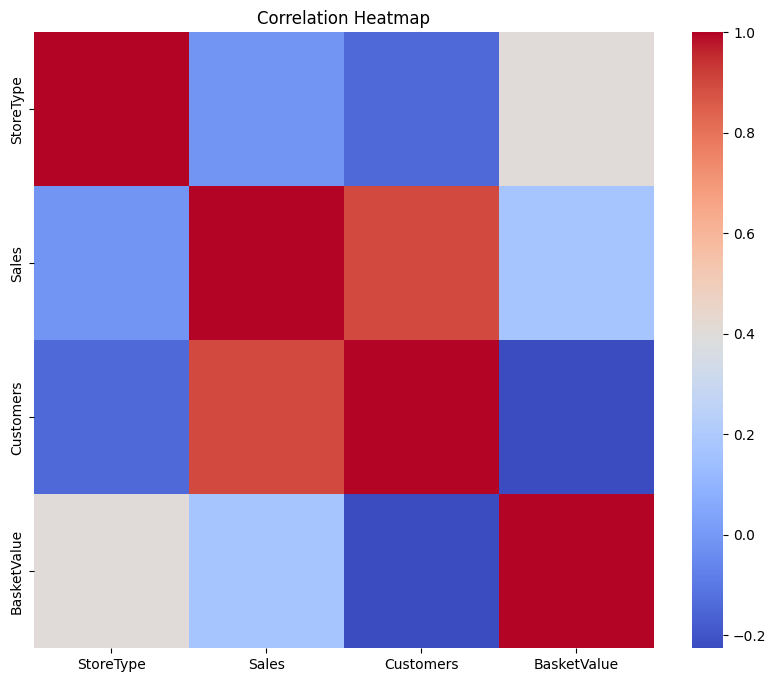

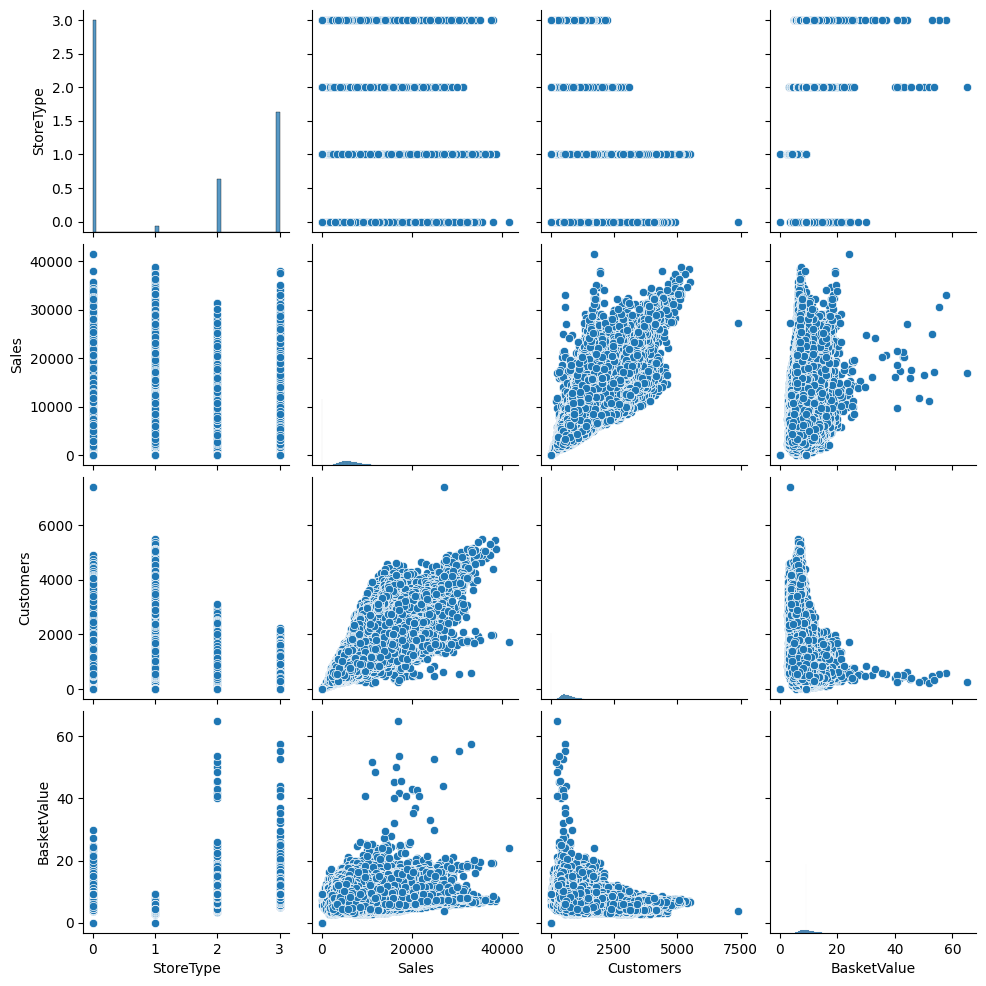

In [32]:
columns = ['StoreType', 'Sales', 'Customers', 'BasketValue']
correlation = df_raw[columns].corr()
print(correlation['StoreType'])

plt.figure(figsize=(10, 8))

sns.heatmap(correlation, annot=False, cmap='coolwarm')
plt.title('Correlation Heatmap')

sns.pairplot(df_raw[columns], height = 2.5)

plt.show()

#### Testy A/B dla sprzedaży

In [33]:
store_types = df_raw['StoreType'].unique()

ABtests(df_raw, store_types, 'StoreType', 'Sales')

Porównanie między 2.0 a 0.0:
Statystyka testowa: -14.55046
Wartość p: 0.27723
Nie ma wystarczających dowodów na odrzucenie H0. Brak istotnej różnicy między grupami.


Porównanie między 2.0 a 3.0:
Statystyka testowa: 81.81
Wartość p: 0.0198
Odrzucamy H0 na poziomie istotności 0.05. Istnieje istotna różnica między grupami.


Porównanie między 2.0 a 1.0:
Statystyka testowa: -4335.20809
Wartość p: 0.0198
Odrzucamy H0 na poziomie istotności 0.05. Istnieje istotna różnica między grupami.


Porównanie między 0.0 a 3.0:
Statystyka testowa: 96.36047
Wartość p: 0.0198
Odrzucamy H0 na poziomie istotności 0.05. Istnieje istotna różnica między grupami.


Porównanie między 0.0 a 1.0:
Statystyka testowa: -4320.65762
Wartość p: 0.0198
Odrzucamy H0 na poziomie istotności 0.05. Istnieje istotna różnica między grupami.


Porównanie między 3.0 a 1.0:
Statystyka testowa: -4417.01809
Wartość p: 0.0198
Odrzucamy H0 na poziomie istotności 0.05. Istnieje istotna różnica między grupami.




#### Testy A/B dla odwiedzających

In [34]:
ABtests(df_raw, store_types, 'StoreType', 'Customers')

Porównanie między 2.0 a 0.0:
Statystyka testowa: 14.23101
Wartość p: 0.0198
Odrzucamy H0 na poziomie istotności 0.05. Istnieje istotna różnica między grupami.


Porównanie między 2.0 a 3.0:
Statystyka testowa: 171.831
Wartość p: 0.0198
Odrzucamy H0 na poziomie istotności 0.05. Istnieje istotna różnica między grupami.


Porównanie między 2.0 a 1.0:
Statystyka testowa: -1314.45495
Wartość p: 0.0198
Odrzucamy H0 na poziomie istotności 0.05. Istnieje istotna różnica między grupami.


Porównanie między 0.0 a 3.0:
Statystyka testowa: 157.59999
Wartość p: 0.0198
Odrzucamy H0 na poziomie istotności 0.05. Istnieje istotna różnica między grupami.


Porównanie między 0.0 a 1.0:
Statystyka testowa: -1328.68597
Wartość p: 0.0198
Odrzucamy H0 na poziomie istotności 0.05. Istnieje istotna różnica między grupami.


Porównanie między 3.0 a 1.0:
Statystyka testowa: -1486.28595
Wartość p: 0.0198
Odrzucamy H0 na poziomie istotności 0.05. Istnieje istotna różnica między grupami.




#### Testy A/B dla wartość koszyka

In [35]:
ABtests(df_raw, store_types, 'StoreType', 'BasketValue')

Porównanie między 2.0 a 0.0:
Statystyka testowa: -0.18046
Wartość p: 0.0198
Odrzucamy H0 na poziomie istotności 0.05. Istnieje istotna różnica między grupami.


Porównanie między 2.0 a 3.0:
Statystyka testowa: -2.19193
Wartość p: 0.0198
Odrzucamy H0 na poziomie istotności 0.05. Istnieje istotna różnica między grupami.


Porównanie między 2.0 a 1.0:
Statystyka testowa: 3.53199
Wartość p: 0.0198
Odrzucamy H0 na poziomie istotności 0.05. Istnieje istotna różnica między grupami.


Porównanie między 0.0 a 3.0:
Statystyka testowa: -2.01148
Wartość p: 0.0198
Odrzucamy H0 na poziomie istotności 0.05. Istnieje istotna różnica między grupami.


Porównanie między 0.0 a 1.0:
Statystyka testowa: 3.71245
Wartość p: 0.0198
Odrzucamy H0 na poziomie istotności 0.05. Istnieje istotna różnica między grupami.


Porównanie między 3.0 a 1.0:
Statystyka testowa: 5.72392
Wartość p: 0.0198
Odrzucamy H0 na poziomie istotności 0.05. Istnieje istotna różnica między grupami.




In [36]:
df_raw['BasketValue']

0           9.482883
1           9.702400
2          10.126675
3           9.342457
4           8.626118
             ...    
1017204     9.250000
1017205     9.250000
1017206     9.250000
1017207     9.250000
1017208     9.250000
Name: BasketValue, Length: 1017209, dtype: float64

#### 4.2.2. Dni wolne od nauki szkolnej

Ilość dni wolnych

In [37]:
print(df_raw['SchoolHoliday'].value_counts())
print(f'Percentage of School Holidays: {df_raw["SchoolHoliday"].mean()*100:.2f}%')

0.0    835488
1.0    181721
Name: SchoolHoliday, dtype: int64
Percentage of School Holidays: 17.86%


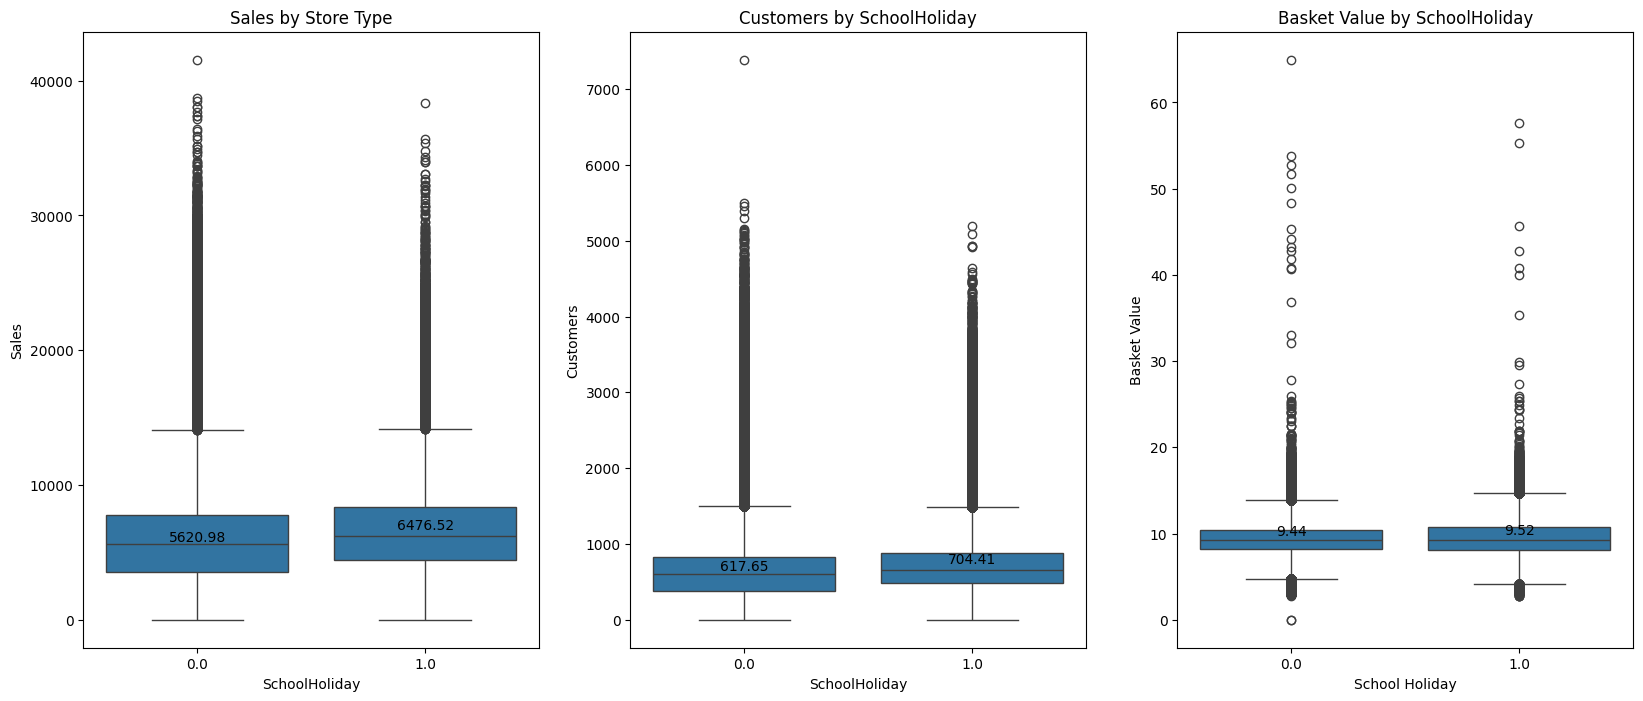

In [38]:
fig, ax = plt.subplots(1, 3, figsize=(20, 8))

sns.boxplot(x='SchoolHoliday', y='Sales', data=df_raw, ax=ax[0])
ax[0].set_title('Sales by Store Type')
ax[0].set_xlabel('SchoolHoliday')
ax[0].set_ylabel('Sales')

mean_sales_value = df_raw.groupby('SchoolHoliday')['Sales'].mean()
for i, mean in enumerate(mean_sales_value):
    ax[0].text(i, mean, f'{mean:.2f}', ha='center', va='bottom')

sns.boxplot(x='SchoolHoliday', y='Customers', data=df_raw, ax=ax[1])
ax[1].set_title('Customers by SchoolHoliday')
ax[1].set_xlabel('SchoolHoliday')
ax[1].set_ylabel('Customers')

mean_customers_value = df_raw.groupby('SchoolHoliday')['Customers'].mean()
for i, mean in enumerate(mean_customers_value):
    ax[1].text(i, mean, f'{mean:.2f}', ha='center', va='bottom')

sns.boxplot(x='SchoolHoliday', y='BasketValue', data=df_raw, ax=ax[2])
ax[2].set_title('Basket Value by SchoolHoliday')
ax[2].set_xlabel('School Holiday')
ax[2].set_ylabel('Basket Value')

mean_basket_value = df_raw.groupby('SchoolHoliday')['BasketValue'].mean()
for i, mean in enumerate(mean_basket_value):
    ax[2].text(i, mean, f'{mean:.2f}', ha='center', va='bottom')

plt.show()


SchoolHoliday    1.000000
Sales            0.085124
Customers        0.071568
BasketValue      0.016316
Name: SchoolHoliday, dtype: float64


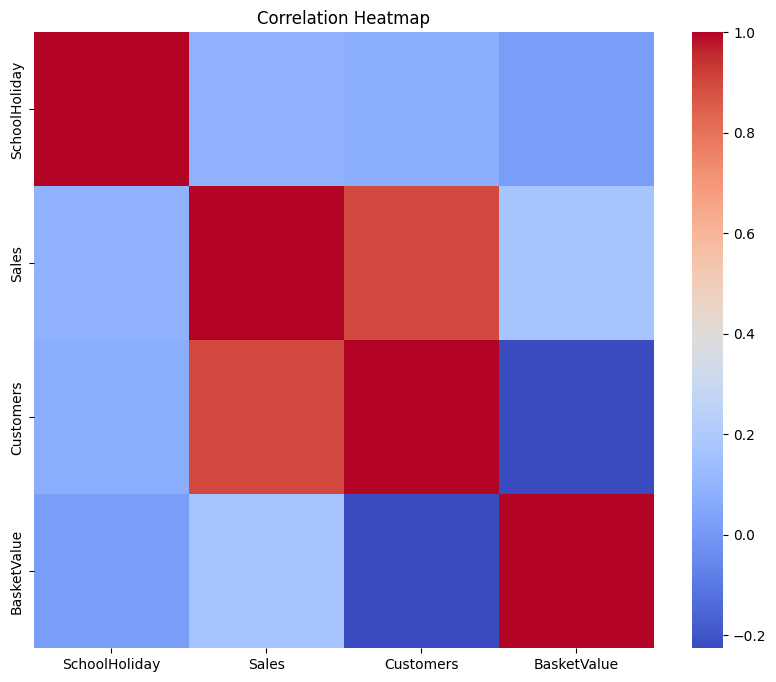

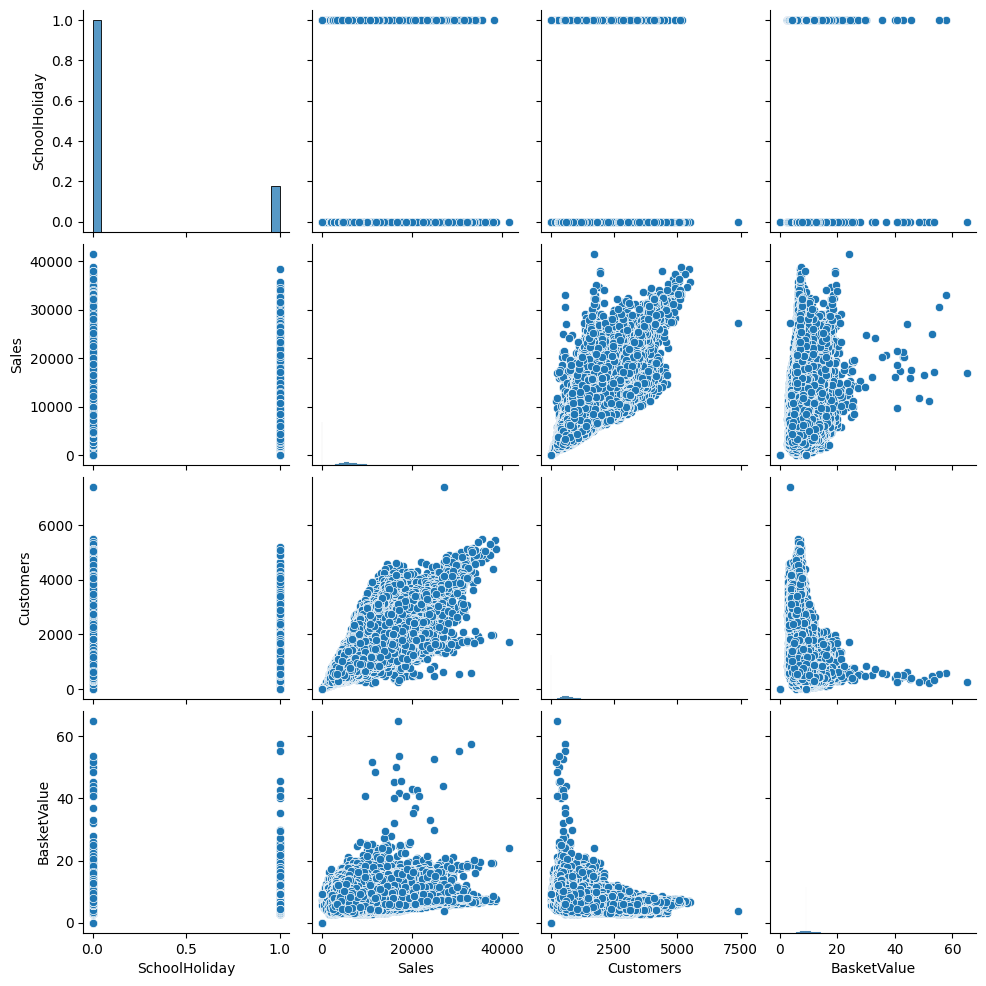

In [39]:
columns = ['SchoolHoliday', 'Sales', 'Customers', 'BasketValue']
correlation = df_raw[columns].corr()
print(correlation['SchoolHoliday'])

plt.figure(figsize=(10, 8))

sns.heatmap(correlation, annot=False, cmap='coolwarm')
plt.title('Correlation Heatmap')

sns.pairplot(df_raw[columns], height = 2.5)

plt.show()

#### Testy A/B dla sprzedaży

In [41]:
store_types = df_raw['SchoolHoliday'].unique()

ABtests(df_raw, store_types, 'SchoolHoliday', 'Sales')

Porównanie między 1.0 a 0.0:
Statystyka testowa: 855.54317
Wartość p: 0.0198
Odrzucamy H0 na poziomie istotności 0.05. Istnieje istotna różnica między grupami.




#### Testy A/B dla odwiedzających

In [42]:
ABtests(df_raw, store_types, 'SchoolHoliday', 'Customers')

Porównanie między 1.0 a 0.0:
Statystyka testowa: 86.76777
Wartość p: 0.0198
Odrzucamy H0 na poziomie istotności 0.05. Istnieje istotna różnica między grupami.




#### Testy A/B dla wartość koszyka

In [43]:
ABtests(df_raw, store_types, 'SchoolHoliday', 'BasketValue')

Porównanie między 1.0 a 0.0:
Statystyka testowa: 0.08537
Wartość p: 0.0198
Odrzucamy H0 na poziomie istotności 0.05. Istnieje istotna różnica między grupami.


